In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import torchvision
from torchvision import transforms, datasets
import copy
import math
import random
from torch.cuda import amp
torch.manual_seed(0)

/home/techlab/Documents/GitHub/Diffusion-CIFAR10/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameters
beta_start = 1e-4
beta_end = 0.02
steps = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = 64
image_channel = 3
epochs = 300
lr = 3e-4
weight_decay = 0
batch_size = 24
num_class = 200
pos_dim = 1024

In [3]:
# This is the utils file
def zero_out(layer):
    for p in layer.parameters():
        p.detach().zero_()
    return layer

def positional_embedding_creator(num_step: int, pos_dim: int):
    matrix = torch.zeros(num_step, pos_dim)
    for i in range(num_step):
        for j in range(0, pos_dim, 2):
            matrix[i, j] = np.sin(i/(10000**(j/pos_dim)))
            if(j+1<pos_dim):
                matrix[i, j+1] = np.cos(i/(10000**(j/pos_dim)))

    return matrix

In [4]:
# Diffusion model

# AdaGN according to paper "Diffusion Models Beat GANs on Image Synthesis"
class AdaNorm(nn.Module):
    def __init__(self, num_channel: int):
        super().__init__()
        num_group = int(num_channel/16) # According to group norm paper, 16 channels per group produces the best result
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor, emb: torch.Tensor):
        scale, shift = torch.chunk(emb, 2, dim=1)

        tensor = self.gnorm(tensor)
        tensor = tensor * (1 + scale) + shift
        return tensor


class MyGroupNorm(nn.Module):
    def __init__(self, num_channel: int):
        super().__init__()
        num_group = int(num_channel/16) # According to group norm paper, 16 channels per group produces the best result
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor):
        return self.gnorm(tensor)


class ResBlock(nn.Module):
    def __init__(self, in_channel: int, out_channel: int, emb_dim: int = 1024, up: bool = False, down: bool = False):
        super().__init__()
        self.emb = nn.Sequential(nn.SiLU(), nn.Linear(emb_dim, 2*out_channel))
        if up:
            self.change_size = nn.Upsample(scale_factor=2, mode='nearest')
        elif down:
            self.change_size = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            self.change_size = nn.Identity()

        # Normalization
        self.gnorm1 = MyGroupNorm(in_channel)
        self.gnorm2 = AdaNorm(out_channel)

        # Convolution
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1)
        if in_channel != out_channel:
            self.conv3 = nn.Conv2d(in_channel, out_channel, kernel_size = 1)
        else:
            self.conv3 = nn.Identity()

        # Combine input stage
        self.input = nn.Sequential(
            self.gnorm1,
            nn.SiLU(),
            self.change_size,
            self.conv1
        )

        # Combine output stage
        self.output = nn.Sequential(
            nn.SiLU(),
            zero_out(self.conv2)
        )

        # Skip connection
        self.skip_connection = nn.Sequential(
            self.change_size,
            self.conv3
        )

        # Embedding
        self.embed = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, 2 * out_channel)
        )

    def forward(self, tensor: torch.Tensor, emb: torch.Tensor):
        emb = self.embed(emb).view(tensor.shape[0], -1, 1, 1)

        h = self.input(tensor)
        h = self.gnorm2(h, emb)
        h = self.output(h)
        x = self.skip_connection(tensor)

        return x + h


class SelfAttention(nn.Module):
    def __init__(self, channel: int):
        super().__init__()
        self.num_head = int(channel/32)

    def forward(self, tensor: torch.Tensor):
        batch, channel, length = tensor.shape
        ch = channel // 3 // self.num_head
        q, k, v = tensor.chunk(3, dim = 1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        # The code below is from Diffusion Model Beat GANs on Image Synthesis paper code
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(batch * self.num_head, ch, length),
            (k * scale).view(batch * self.num_head, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(batch * self.num_head, ch, length))
        return a.reshape(batch, -1, length)


class Attention(nn.Module):
    def __init__(self, channel: int):
        super().__init__()
        self.gnorm = MyGroupNorm(channel)
        self.qkv = nn.Conv1d(channel, channel * 3, 1)
        self.attention = SelfAttention(channel)
        self.output = zero_out(nn.Conv1d(channel, channel, 1))

    def forward(self, tensor: torch.Tensor):
        # Perform self attention
        batch, channel, width, height = tensor.shape
        tensor = tensor.reshape(batch, channel, -1)
        # Skip connection
        tensor_skip = tensor
        tensor = self.gnorm(tensor)
        tensor = self.qkv(tensor)
        tensor = self.attention(tensor)
        tensor = self.output(tensor)

        # Adding the skip connection tensor back to the current tensor
        tensor = tensor + tensor_skip

        tensor = tensor.reshape(batch, channel, width, height)
        return tensor


class UNet(nn.Module):
    def __init__(self, image_channel: int = 3, depth: int = 2, emb_dim: int = 1024, num_step = 1000, num_classes = 10):
        super().__init__()

        # Create model architecture
        channels = [160, 320, 544, 608]
        attention_channel = [544, 608]
        self.encoder = nn.ModuleList([nn.ModuleList([nn.Conv2d(image_channel, channels[0], 3, padding=1)])])
        self.decoder = nn.ModuleList()

        skip_channel = [channels[0]]

        # Encoder
        for i in range(len(channels)):
            for _ in range(depth):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channel:
                    layer.append(Attention(channels[i]))
                self.encoder.append(layer)
                skip_channel.append(channels[i])

            if i != len(channels)-1:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i + 1], down=True, emb_dim = emb_dim))
                self.encoder.append(layer)
                skip_channel.append(channels[i+1])

        # Bottleneck
        self.bottle_neck = nn.ModuleList([
            ResBlock(channels[-1], channels[-1]),
            Attention(channels[-1]),
            ResBlock(channels[-1], channels[-1]),
        ])

        # Decoder
        for i in range(len(channels)-1, -1, -1):
            for block in range(depth+1):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channel:
                    layer.append(Attention(channels[i]))

                if i != 0 and block == depth:
                    layer.append(ResBlock(channels[i], channels[i - 1], up=True, emb_dim = emb_dim))

                self.decoder.append(layer)

        # Create time embedding
        self.time_embedding = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        # Create class embedding
        self.class_embedding = nn.Embedding(num_classes, emb_dim)

        # Output kernels to change back to image channel
        self.out = nn.Sequential(
            MyGroupNorm(channels[0]),
            nn.SiLU(),
            zero_out(nn.Conv2d(channels[0], image_channel, 3, padding=1)),
        )

    def forward(self, tensor: torch.Tensor, time_embedding: torch.Tensor, label: torch.Tensor | None):
        # Creating embedding
        embedding = self.time_embedding(time_embedding)
        
        if label != None:
            class_embedding = self.class_embedding(label)
            embedding = embedding + class_embedding
        skip_connection = []

        # Encoder
        for layer in self.encoder:
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

            skip_connection.append(tensor)

        # Bottleneck
        for module in self.bottle_neck:
            if(isinstance(module, ResBlock)):
                tensor = module(tensor, embedding)
            else:
                tensor = module(tensor)

        # Decoder
        for layer in self.decoder:
            tensor = torch.concatenate((tensor, skip_connection.pop()), dim = 1)
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

        tensor = self.out(tensor)

        return tensor

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [5]:
# Constants used for diffusion model
beta = torch.linspace(beta_start, beta_end, steps).to(device)
sqrt_beta = torch.sqrt(beta).view(-1, 1, 1, 1)
alpha = 1 - beta
alphas_cumprod = torch.cumprod(alpha, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).view(-1, 1, 1, 1)
one_minus_alphas_cumprod = 1 - alphas_cumprod
sqrt_one_minus_alphas_cumprod = torch.sqrt(one_minus_alphas_cumprod).view(-1, 1, 1, 1)
one_over_sqrt_alpha = 1/torch.sqrt(alpha).view(-1, 1, 1, 1)
one_minus_alpha = (1 - alpha).view(-1, 1, 1, 1)

In [6]:
# Forward pass
def forward_pass(images, t):
    batch_sqrt_alphas_cumprod = sqrt_alphas_cumprod[t]
    batch_sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod[t]
    noise = torch.randn_like(images).to(device)

    return batch_sqrt_alphas_cumprod * images + batch_sqrt_one_minus_alphas_cumprod * noise, noise

In [7]:
# Positional embedding
pos_emb_matrix = positional_embedding_creator(steps, pos_dim).to(device)

In [8]:
# Sampling(inference)

def sampling(model, labels, cfg_scale: int = 3):
    model.eval()
    with torch.no_grad():
        x = torch.randn(labels.shape[0], image_channel, image_size, image_size).to(device)

        for i in range(steps-1, -1, -1):
            t = torch.tensor([i]*labels.shape[0]).to(device)
            pos_emb = pos_emb_matrix[t]

            # Classifier free guidance
            predicted_noise_no_label = model(x, pos_emb, None)
            predicted_noise_with_label = model(x, pos_emb, labels)
            predicted_noise = torch.lerp(predicted_noise_no_label, predicted_noise_with_label, cfg_scale)

            if(i == 0):
                noise = torch.zeros_like(x).to(device)
            else:
                noise = torch.randn_like(x).to(device)

            x = one_over_sqrt_alpha[t] * (x - ((one_minus_alpha[t])/(sqrt_one_minus_alphas_cumprod[t]))*predicted_noise) + sqrt_beta[t] * noise

    model.train()

    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)

    for i in range(x.shape[0]):
        tensor = x[i].permute(1, 2, 0).to("cpu")
        plt.imshow(tensor)
        plt.show()

In [9]:
# Define the transformation\n",
transform = transforms.Compose([
    transforms.Resize(125),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load the test set
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the combined dataset
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Instantiate the model
unet = UNet(num_classes=num_class).to(device)
print("This model has", sum(p.numel() for p in unet.parameters()), "parameters.")
scaler = amp.GradScaler()
loss_train = []
loss_valid = []

This model has 227992835 parameters.


In [11]:
# Set up optimizer and loss
optimizer = opt.AdamW(unet.parameters(), lr = lr, weight_decay = weight_decay)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.991)

100%|█████████████████████████████████████| 10000/10000 [02:16<00:00, 73.11it/s]


Epoch #0
Current learning rate is 0.00029729999999999996
Train Loss is: 0.021074148461190472
Valid Loss is: 0.011914222799913842


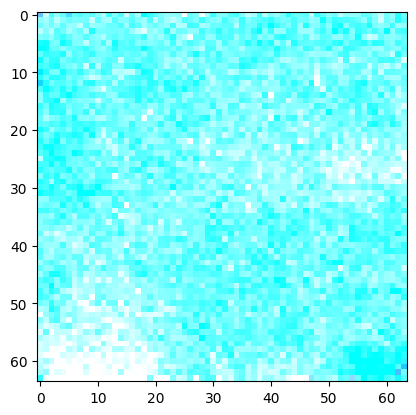

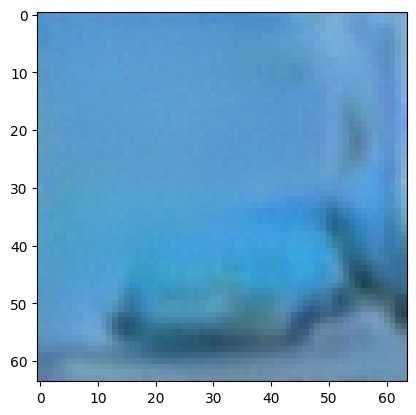

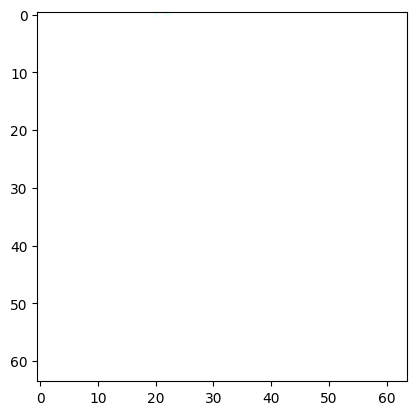

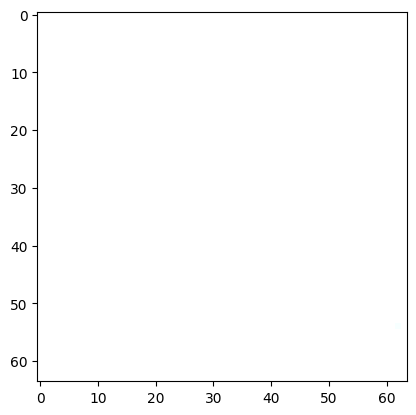

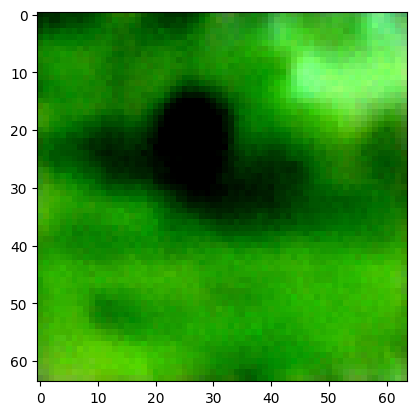

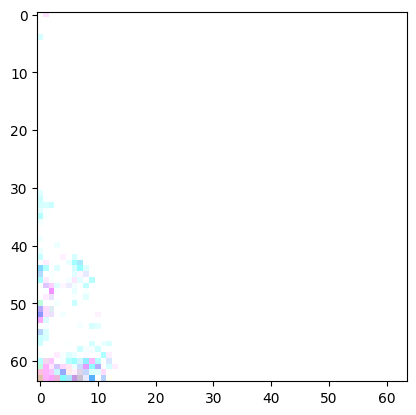

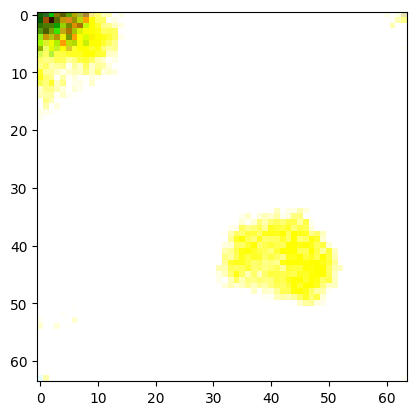

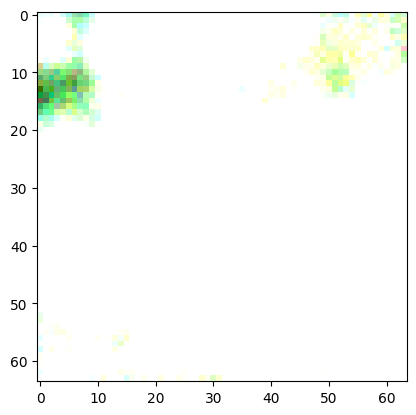

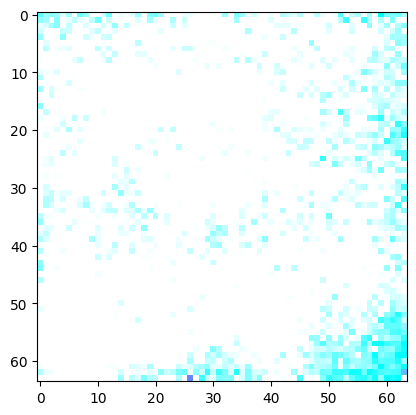

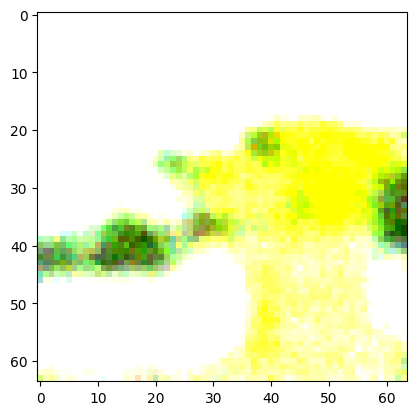

100%|███████████████████████████████████████| 2084/2084 [17:31<00:00,  1.98it/s]


Epoch #1
Current learning rate is 0.00029462429999999994
Train Loss is: 0.01166780872131705


100%|███████████████████████████████████████| 2084/2084 [17:33<00:00,  1.98it/s]


Epoch #2
Current learning rate is 0.00029197268129999997
Train Loss is: 0.011009447038957523


100%|███████████████████████████████████████| 2084/2084 [17:34<00:00,  1.98it/s]


Epoch #3
Current learning rate is 0.00028934492716829995
Train Loss is: 0.01099102574433227


100%|███████████████████████████████████████| 2084/2084 [17:35<00:00,  1.97it/s]


Epoch #4
Current learning rate is 0.00028674082282378524
Train Loss is: 0.01085577245096492


100%|███████████████████████████████████████| 2084/2084 [17:35<00:00,  1.97it/s]


Epoch #5
Current learning rate is 0.0002841601554183712
Train Loss is: 0.010687827694608746


100%|███████████████████████████████████████| 2084/2084 [17:35<00:00,  1.97it/s]


Epoch #6
Current learning rate is 0.00028160271401960586
Train Loss is: 0.01074087515141772


100%|███████████████████████████████████████| 2084/2084 [17:34<00:00,  1.98it/s]


Epoch #7
Current learning rate is 0.0002790682895934294
Train Loss is: 0.010590870358025738


100%|███████████████████████████████████████| 2084/2084 [17:34<00:00,  1.98it/s]


Epoch #8
Current learning rate is 0.00027655667498708853
Train Loss is: 0.01063442578532102


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #9
Current learning rate is 0.00027406766491220474
Train Loss is: 0.010636982750219084


100%|█████████████████████████████████████| 10000/10000 [02:15<00:00, 73.80it/s]


Epoch #10
Current learning rate is 0.0002716010559279949
Train Loss is: 0.010475756509333219
Valid Loss is: 0.010676561522025804


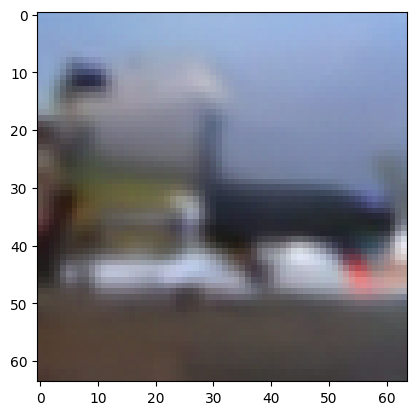

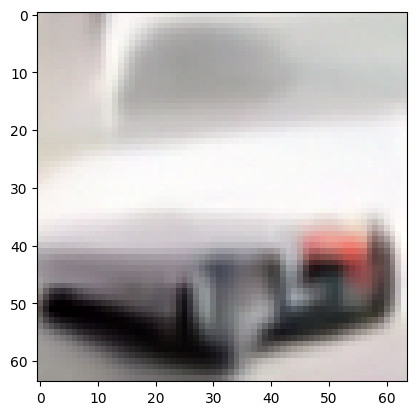

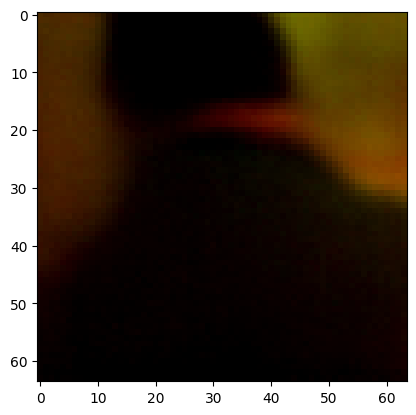

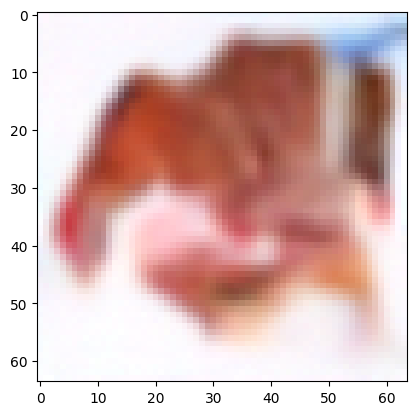

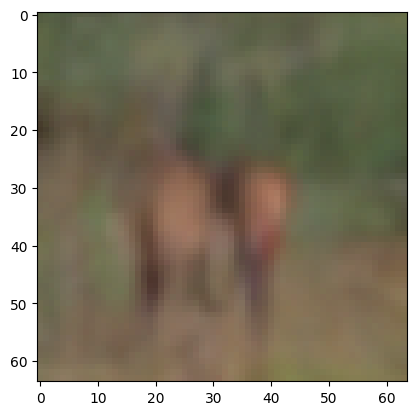

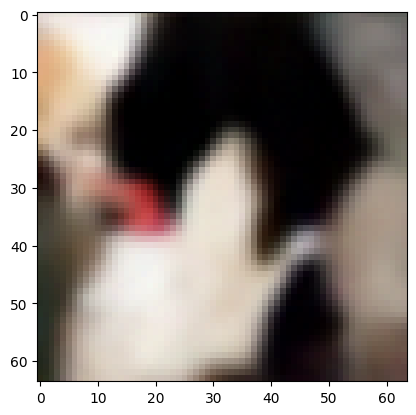

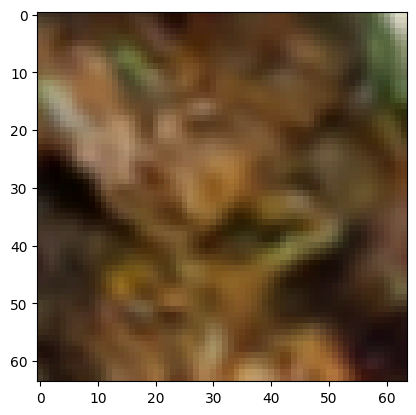

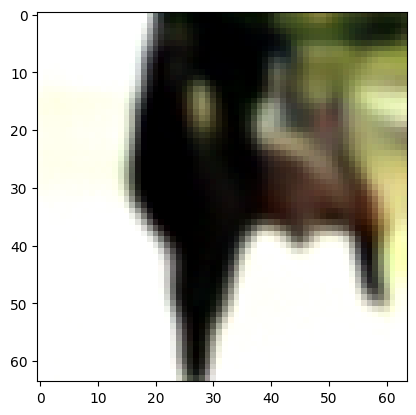

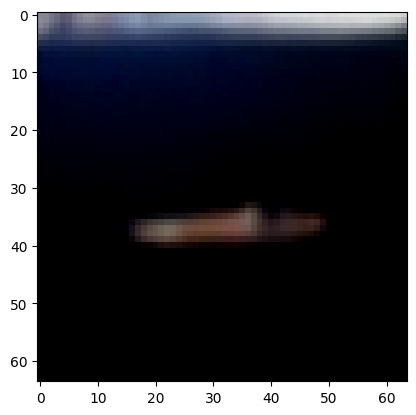

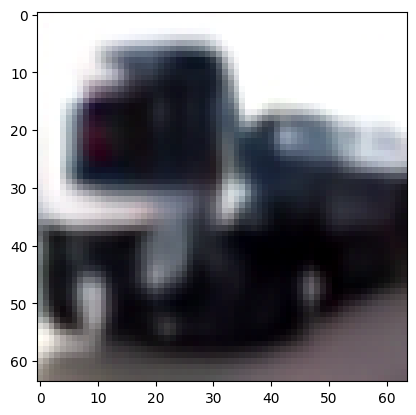

100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #11
Current learning rate is 0.0002691566464246429
Train Loss is: 0.010592740439231581


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #12
Current learning rate is 0.00026673423660682113
Train Loss is: 0.010581815478659187


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #13
Current learning rate is 0.00026433362847735973
Train Loss is: 0.010521227680962272


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #14
Current learning rate is 0.0002619546258210635
Train Loss is: 0.010559956622023973


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #15
Current learning rate is 0.0002595970341886739
Train Loss is: 0.010571655133920553


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #16
Current learning rate is 0.0002572606608809758
Train Loss is: 0.010581634997483165


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #17
Current learning rate is 0.000254945314933047
Train Loss is: 0.010415255244139353


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #18
Current learning rate is 0.00025265080709864957
Train Loss is: 0.010342870576949808


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #19
Current learning rate is 0.0002503769498347617
Train Loss is: 0.010552558445080315


100%|█████████████████████████████████████| 10000/10000 [02:16<00:00, 73.41it/s]


Epoch #20
Current learning rate is 0.00024812355728624883
Train Loss is: 0.010446483555903226
Valid Loss is: 0.010509414651777115


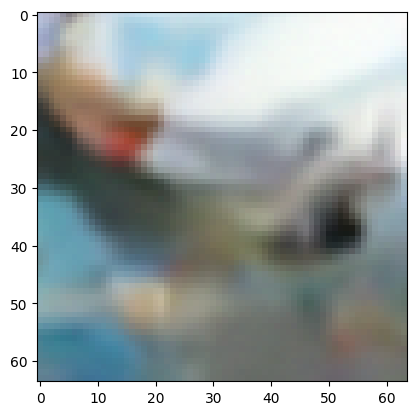

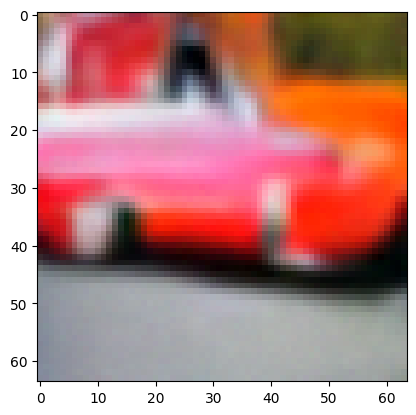

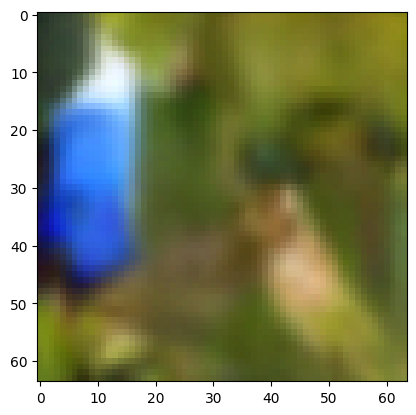

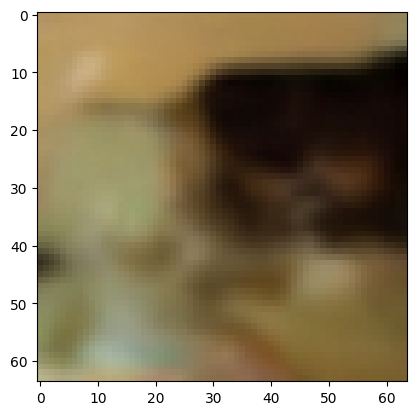

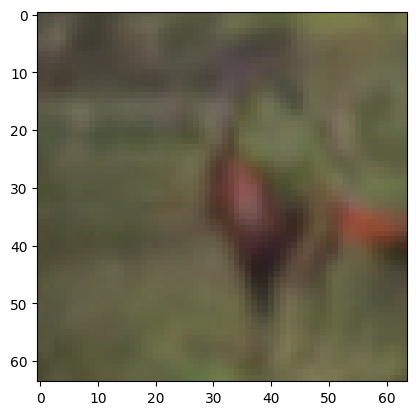

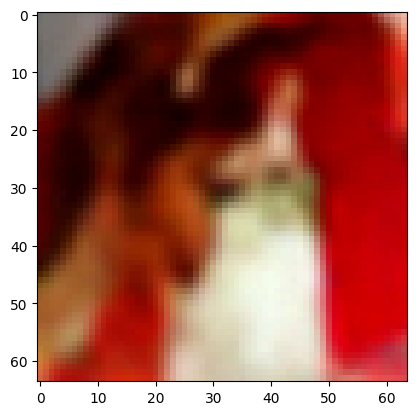

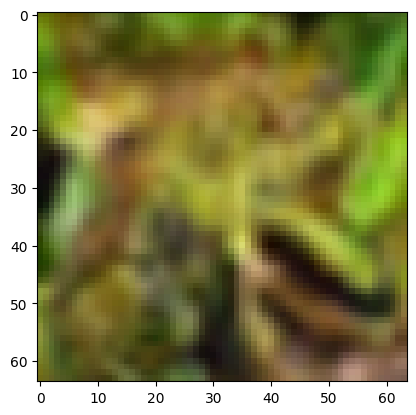

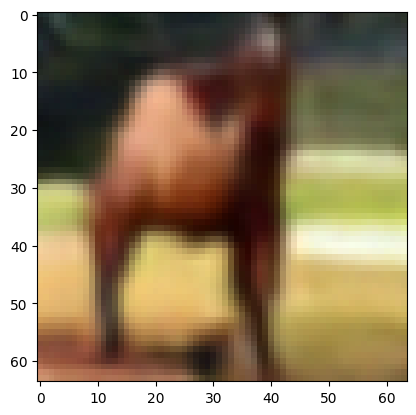

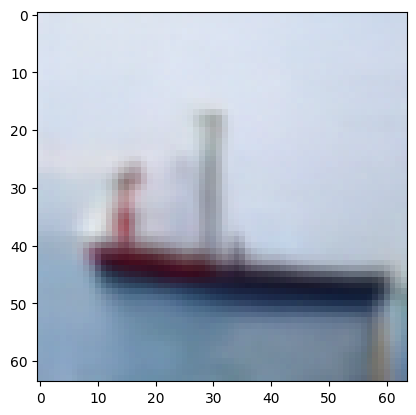

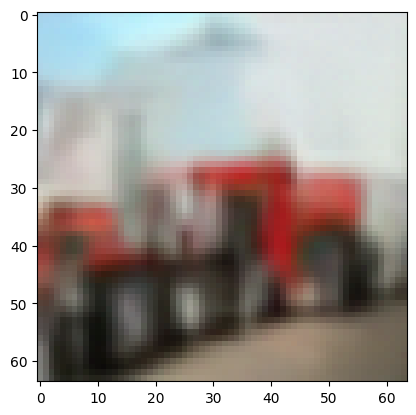

100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #21
Current learning rate is 0.00024589044527067257
Train Loss is: 0.01059909929917328


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #22
Current learning rate is 0.0002436774312632365
Train Loss is: 0.010318220574936102


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #23
Current learning rate is 0.00024148433438186736
Train Loss is: 0.010505155405036805


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #24
Current learning rate is 0.00023931097537243057
Train Loss is: 0.010517899565722242


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #25
Current learning rate is 0.00023715717659407868
Train Loss is: 0.010349478122028353


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #26
Current learning rate is 0.00023502276200473198
Train Loss is: 0.010495824323951011


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #27
Current learning rate is 0.00023290755714668938
Train Loss is: 0.010366873681811606


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #28
Current learning rate is 0.00023081138913236916
Train Loss is: 0.010382078133128858


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #29
Current learning rate is 0.00022873408663017783
Train Loss is: 0.010371418976164181


100%|█████████████████████████████████████| 10000/10000 [02:16<00:00, 73.22it/s]


Epoch #30
Current learning rate is 0.00022667547985050622
Train Loss is: 0.010330645991475885
Valid Loss is: 0.010237209097506274


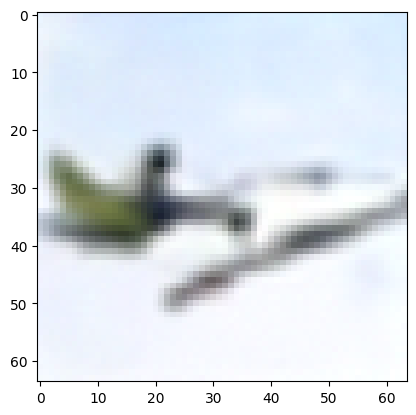

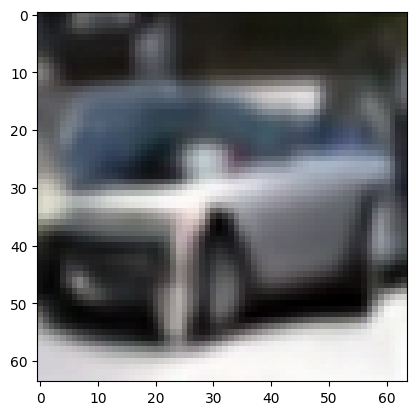

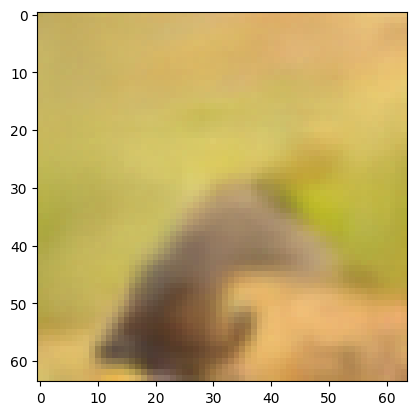

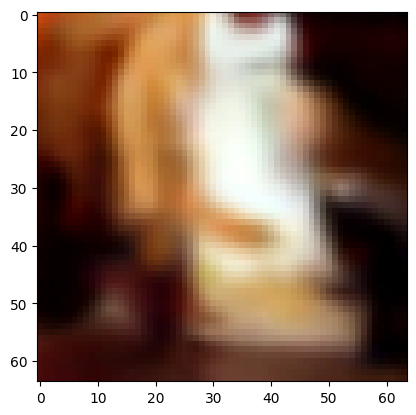

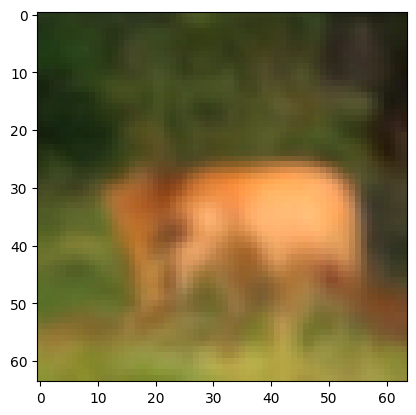

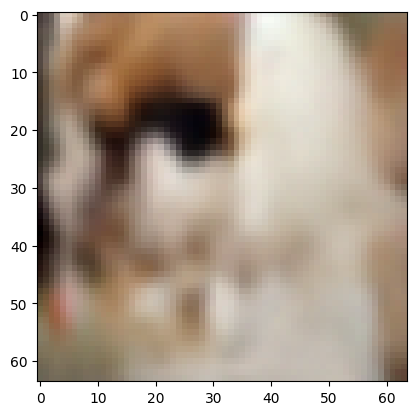

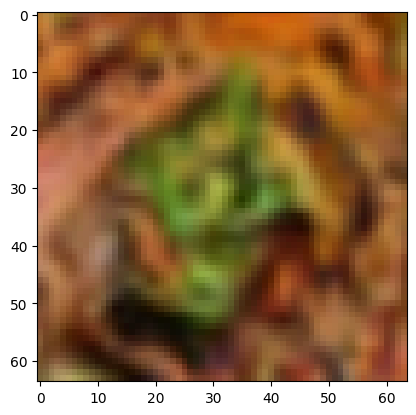

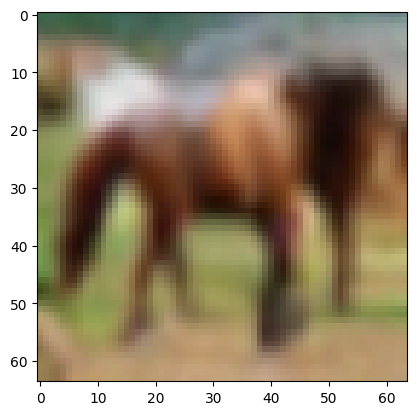

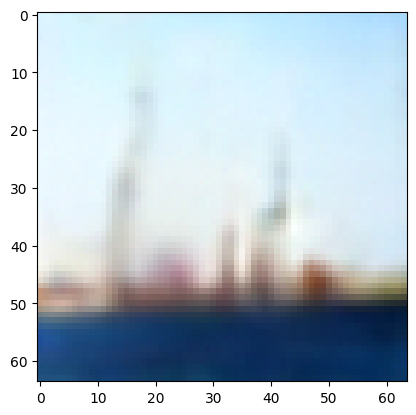

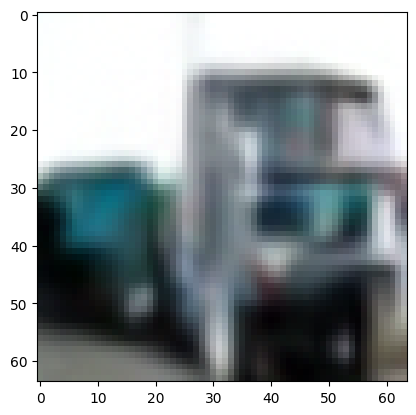

100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #31
Current learning rate is 0.00022463540053185166
Train Loss is: 0.01034962399791204


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #32
Current learning rate is 0.00022261368192706498
Train Loss is: 0.01039045014429387


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #33
Current learning rate is 0.00022061015878972138
Train Loss is: 0.010463747569724503


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #34
Current learning rate is 0.00021862466736061387
Train Loss is: 0.010223362036675015


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #35
Current learning rate is 0.00021665704535436836
Train Loss is: 0.010290432207841845


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #36
Current learning rate is 0.00021470713194617904
Train Loss is: 0.010400280500194613


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #37
Current learning rate is 0.00021277476775866344
Train Loss is: 0.010381516961728522


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #38
Current learning rate is 0.00021085979484883547
Train Loss is: 0.010423069817461824


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #39
Current learning rate is 0.00020896205669519594
Train Loss is: 0.010340069906965735


100%|█████████████████████████████████████| 10000/10000 [02:14<00:00, 74.17it/s]


Epoch #40
Current learning rate is 0.00020708139818493917
Train Loss is: 0.010380853950327545
Valid Loss is: 0.009962873875673177


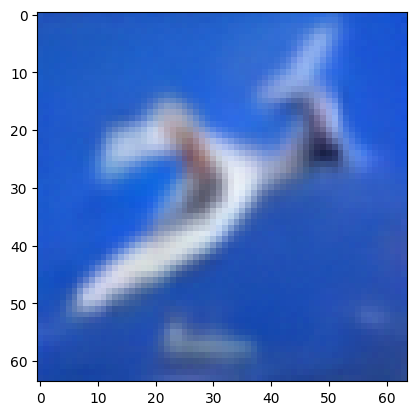

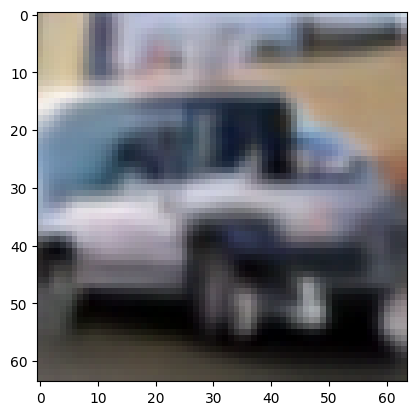

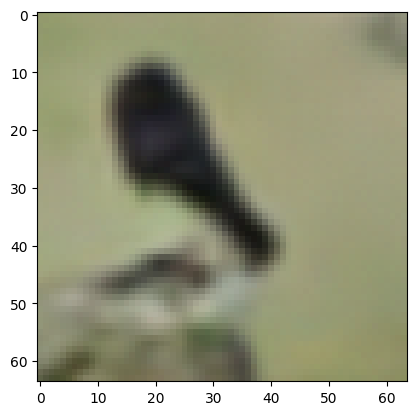

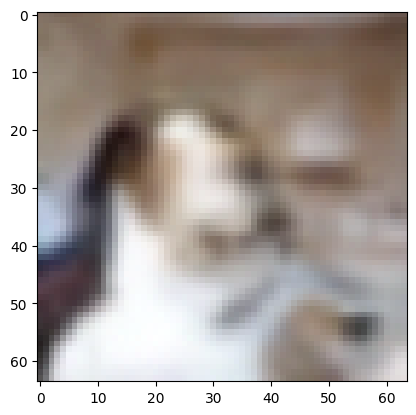

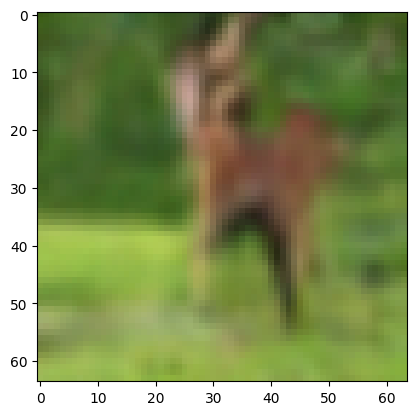

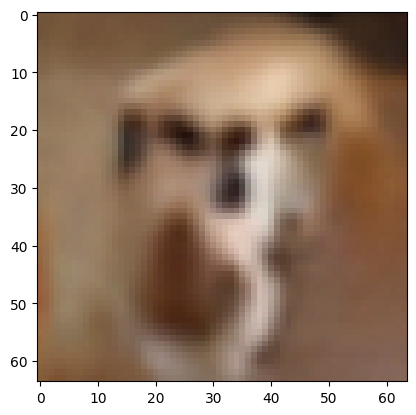

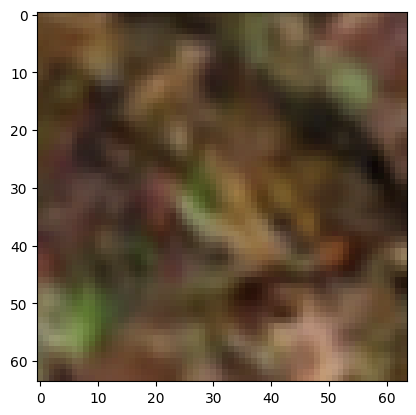

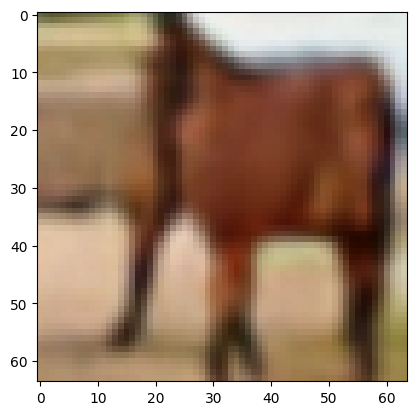

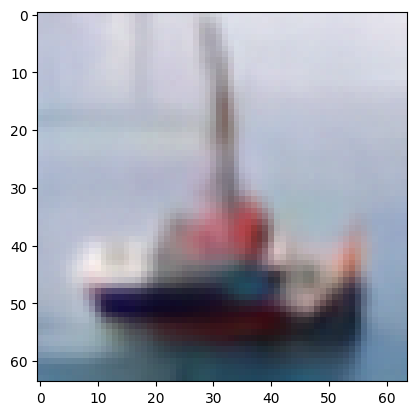

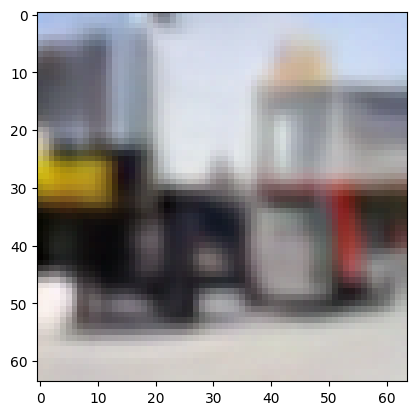

100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #41
Current learning rate is 0.00020521766560127472
Train Loss is: 0.010264753601661278


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #42
Current learning rate is 0.00020337070661086325
Train Loss is: 0.010204925970263751


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #43
Current learning rate is 0.00020154037025136548
Train Loss is: 0.010329754562376357


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #44
Current learning rate is 0.0001997265069191032
Train Loss is: 0.010387068770999257


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #45
Current learning rate is 0.00019792896835683126
Train Loss is: 0.01034792499270848


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #46
Current learning rate is 0.00019614760764161978
Train Loss is: 0.010281982658821517


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #47
Current learning rate is 0.0001943822791728452
Train Loss is: 0.010304331573071816


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #48
Current learning rate is 0.0001926328386602896
Train Loss is: 0.01018800273648912


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #49
Current learning rate is 0.000190899143112347
Train Loss is: 0.010302803918764874


100%|█████████████████████████████████████| 10000/10000 [02:15<00:00, 73.91it/s]


Epoch #50
Current learning rate is 0.00018918105082433586
Train Loss is: 0.010146955688012096
Valid Loss is: 0.01015223856330922


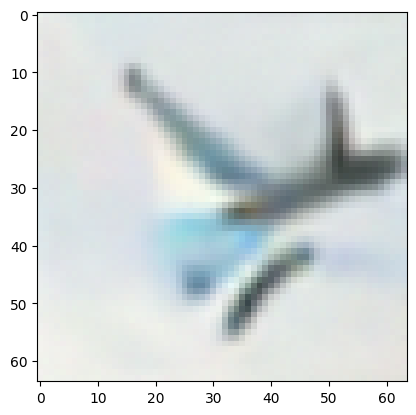

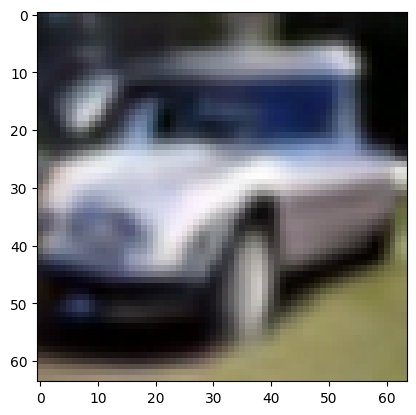

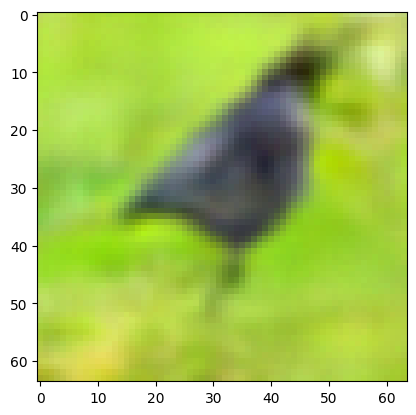

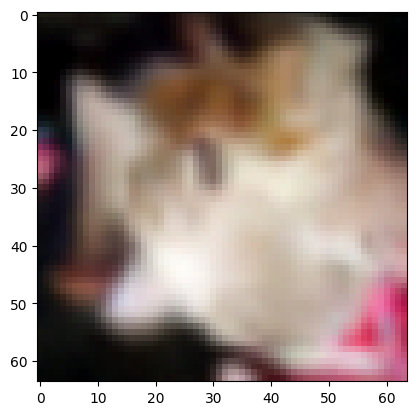

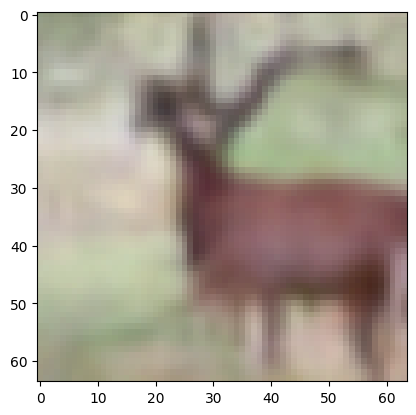

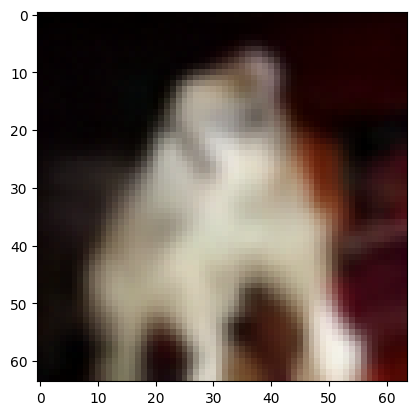

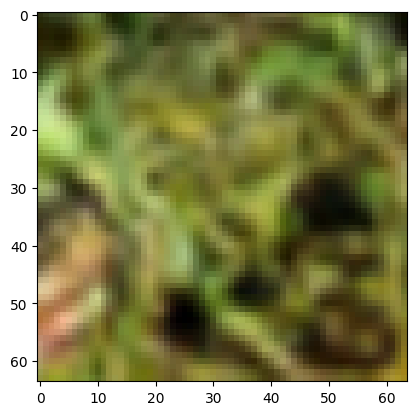

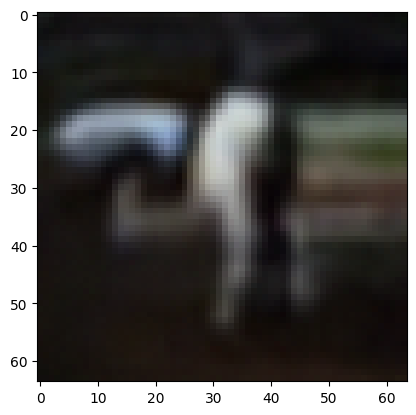

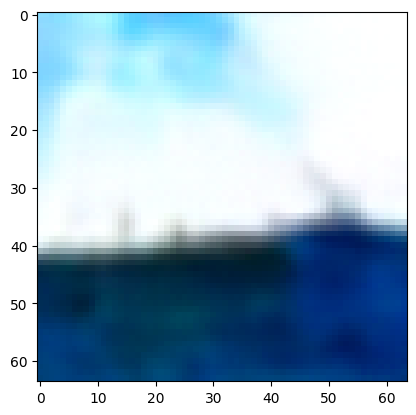

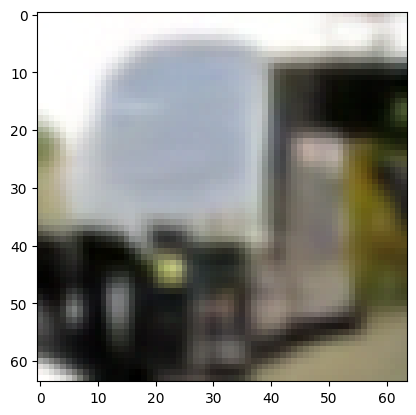

100%|███████████████████████████████████████| 2084/2084 [17:16<00:00,  2.01it/s]


Epoch #51
Current learning rate is 0.00018747842136691685
Train Loss is: 0.01002637186638909


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #52
Current learning rate is 0.0001857911155746146
Train Loss is: 0.010077444411056284


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #53
Current learning rate is 0.00018411899553444306
Train Loss is: 0.010196903301592855


100%|███████████████████████████████████████| 2084/2084 [17:18<00:00,  2.01it/s]


Epoch #54
Current learning rate is 0.00018246192457463308
Train Loss is: 0.010300928409387414


100%|███████████████████████████████████████| 2084/2084 [17:17<00:00,  2.01it/s]


Epoch #55
Current learning rate is 0.00018081976725346137
Train Loss is: 0.010126697302071087


100%|███████████████████████████████████████| 2084/2084 [17:16<00:00,  2.01it/s]


Epoch #56
Current learning rate is 0.00017919238934818022
Train Loss is: 0.010099457051214403


100%|███████████████████████████████████████| 2084/2084 [17:16<00:00,  2.01it/s]


Epoch #57
Current learning rate is 0.0001775796578440466
Train Loss is: 0.010166510365565528


100%|███████████████████████████████████████| 2084/2084 [17:18<00:00,  2.01it/s]


Epoch #58
Current learning rate is 0.00017598144092345017
Train Loss is: 0.010150480199251735


100%|███████████████████████████████████████| 2084/2084 [17:17<00:00,  2.01it/s]


Epoch #59
Current learning rate is 0.00017439760795513913
Train Loss is: 0.010242380471180609


100%|█████████████████████████████████████| 10000/10000 [02:15<00:00, 74.06it/s]


Epoch #60
Current learning rate is 0.00017282802948354286
Train Loss is: 0.010096736476871036
Valid Loss is: 0.010207678449352534


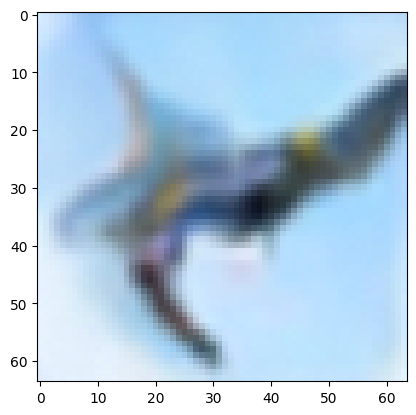

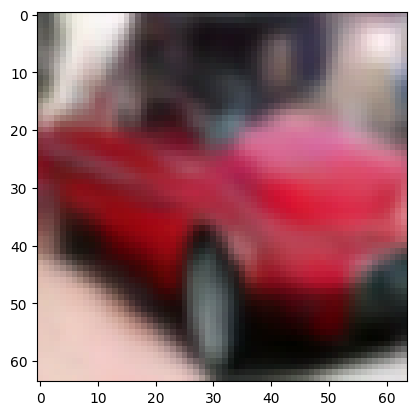

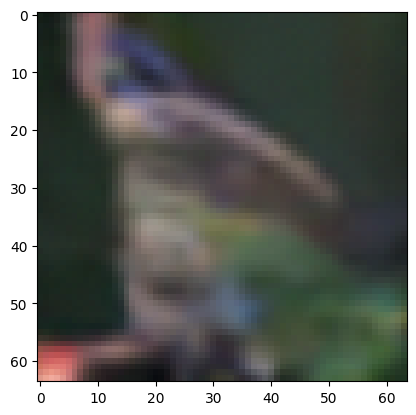

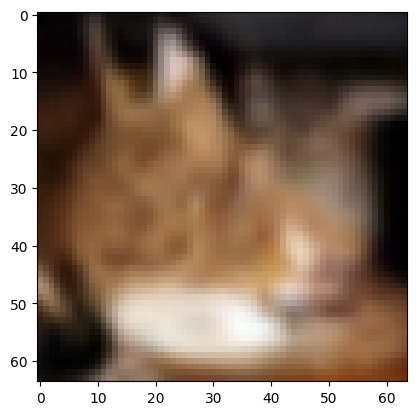

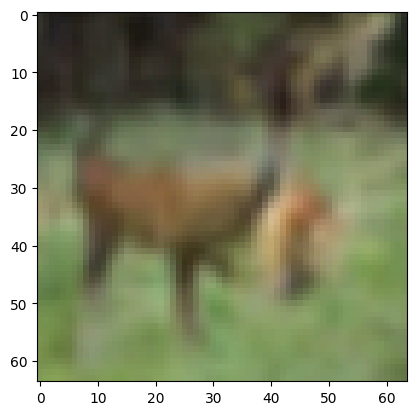

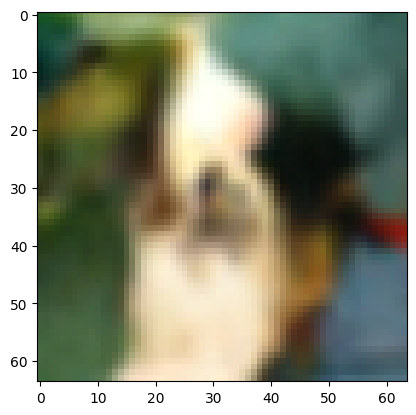

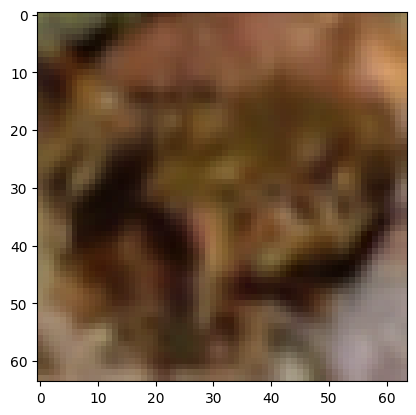

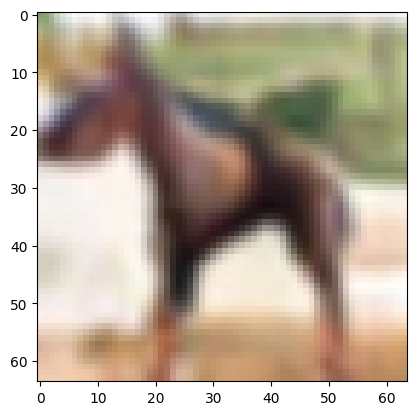

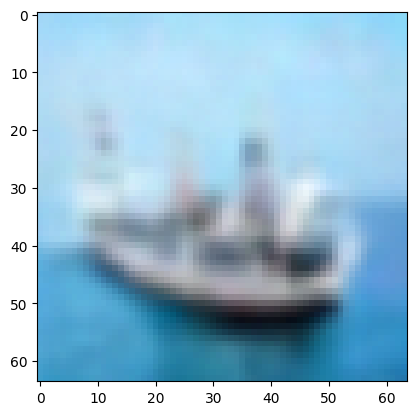

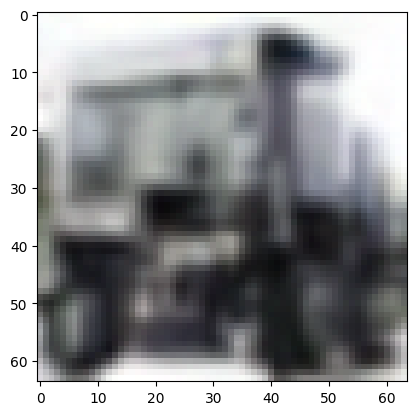

100%|███████████████████████████████████████| 2084/2084 [17:16<00:00,  2.01it/s]


Epoch #61
Current learning rate is 0.00017127257721819098
Train Loss is: 0.010126835324948085


100%|███████████████████████████████████████| 2084/2084 [17:19<00:00,  2.01it/s]


Epoch #62
Current learning rate is 0.00016973112402322727
Train Loss is: 0.010280119925299426


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #63
Current learning rate is 0.0001682035439070182
Train Loss is: 0.010178168390067776


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #64
Current learning rate is 0.00016668971201185505
Train Loss is: 0.010208357013686026


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #65
Current learning rate is 0.00016518950460374835
Train Loss is: 0.010289058026021092


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #66
Current learning rate is 0.0001637027990623146
Train Loss is: 0.010100298703602567


100%|███████████████████████████████████████| 2084/2084 [17:15<00:00,  2.01it/s]


Epoch #67
Current learning rate is 0.00016222947387075376
Train Loss is: 0.010150953251347858


100%|███████████████████████████████████████| 2084/2084 [17:17<00:00,  2.01it/s]


Epoch #68
Current learning rate is 0.00016076940860591698
Train Loss is: 0.010064274490937847


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #69
Current learning rate is 0.00015932248392846372
Train Loss is: 0.00999494077935645


100%|█████████████████████████████████████| 10000/10000 [02:15<00:00, 73.61it/s]


Epoch #70
Current learning rate is 0.00015788858157310756
Train Loss is: 0.010094142604070482
Valid Loss is: 0.009933806230606206


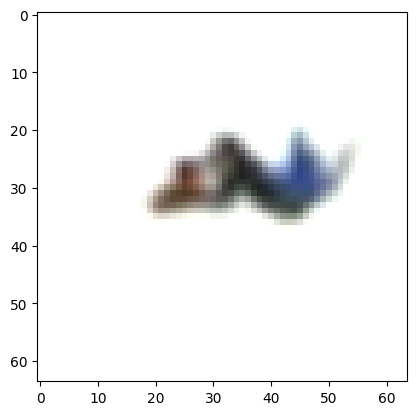

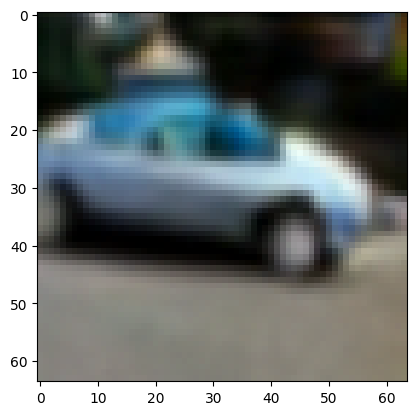

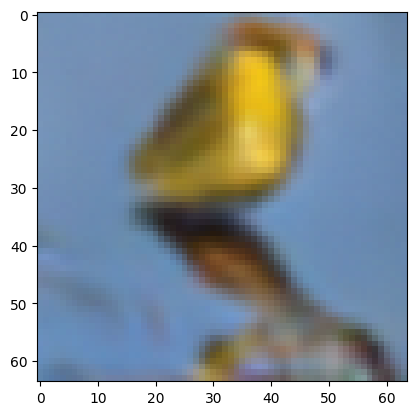

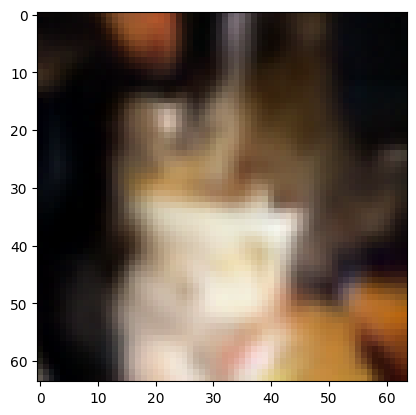

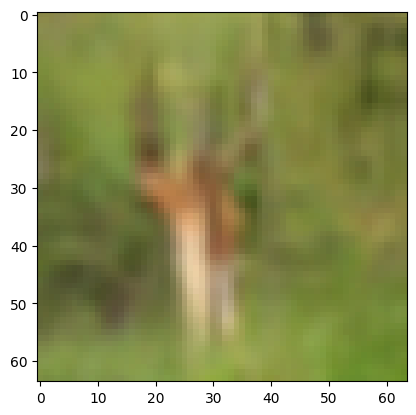

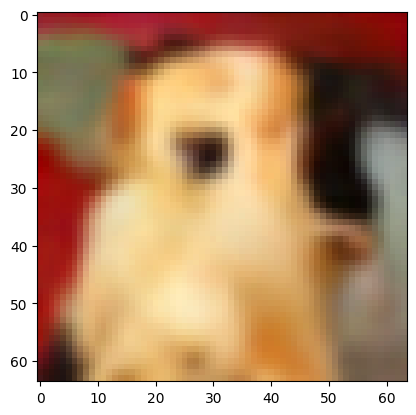

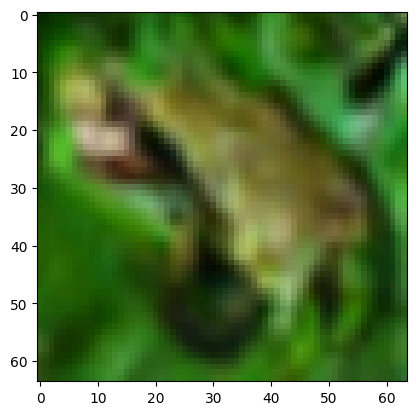

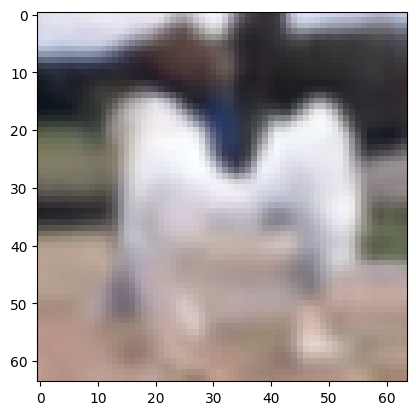

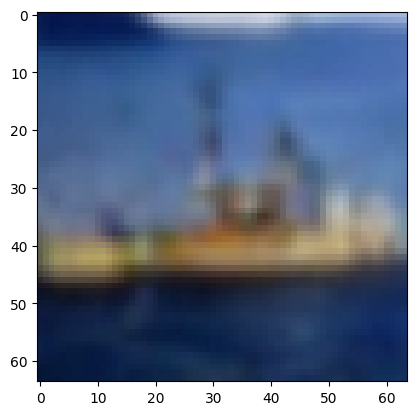

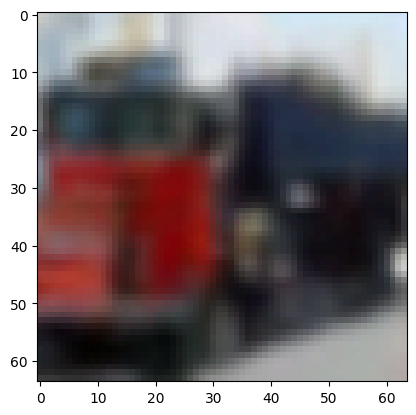

100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #71
Current learning rate is 0.0001564675843389496
Train Loss is: 0.010166355687309317


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #72
Current learning rate is 0.00015505937607989906
Train Loss is: 0.010082082569196056


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #73
Current learning rate is 0.00015366384169517995
Train Loss is: 0.010138249283275726


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #74
Current learning rate is 0.00015228086711992334
Train Loss is: 0.010226469770169526


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #75
Current learning rate is 0.00015091033931584403
Train Loss is: 0.010119346040725572


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #76
Current learning rate is 0.00014955214626200143
Train Loss is: 0.010132662080842358


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #77
Current learning rate is 0.00014820617694564342
Train Loss is: 0.010098723708759213


100%|███████████████████████████████████████| 2084/2084 [17:23<00:00,  2.00it/s]


Epoch #78
Current learning rate is 0.00014687232135313262
Train Loss is: 0.010106457805577415


100%|███████████████████████████████████████| 2084/2084 [17:23<00:00,  2.00it/s]


Epoch #79
Current learning rate is 0.00014555047046095441
Train Loss is: 0.010093840517929529


100%|█████████████████████████████████████| 10000/10000 [02:16<00:00, 73.48it/s]


Epoch #80
Current learning rate is 0.0001442405162268058
Train Loss is: 0.01010709006601637
Valid Loss is: 0.010020141668780888


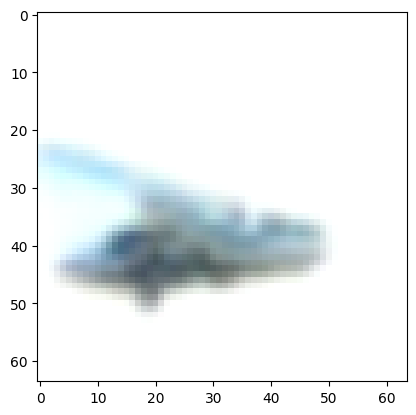

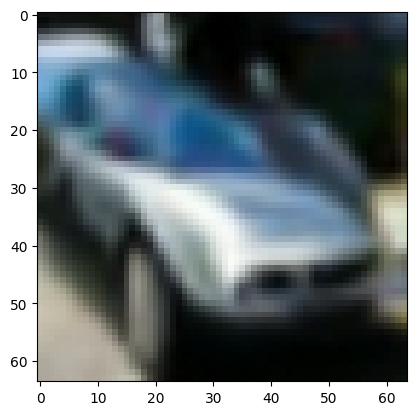

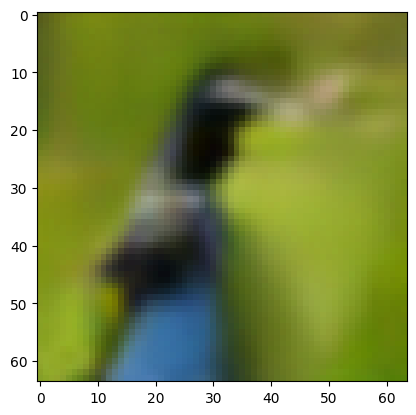

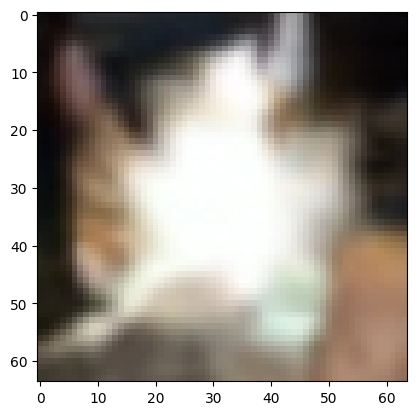

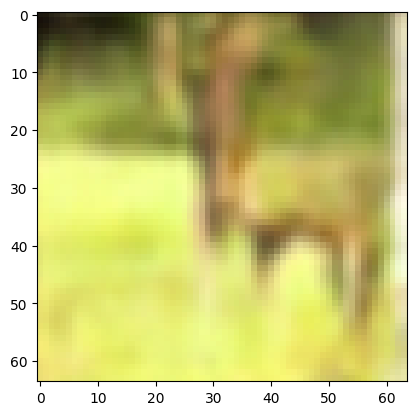

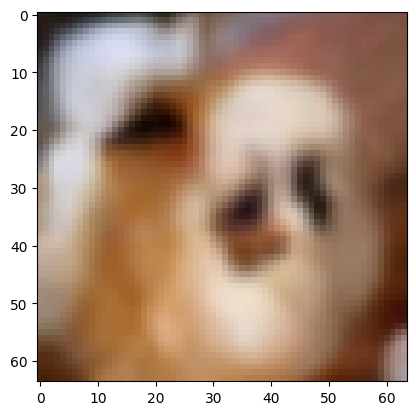

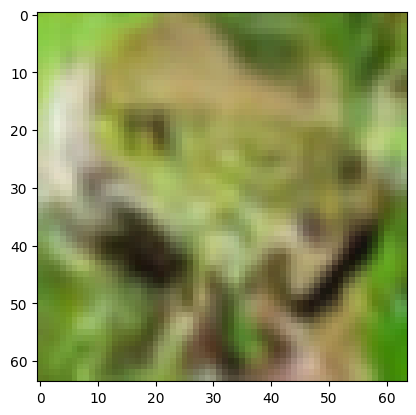

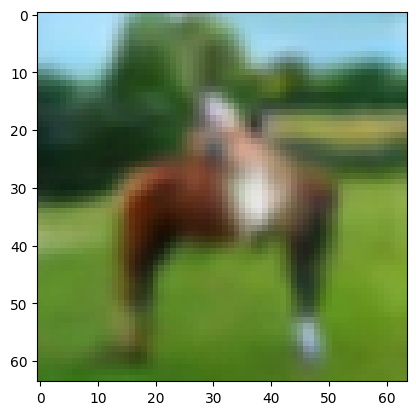

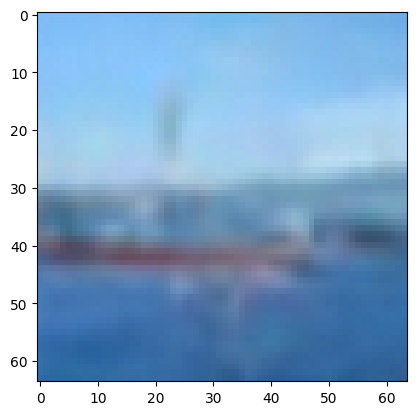

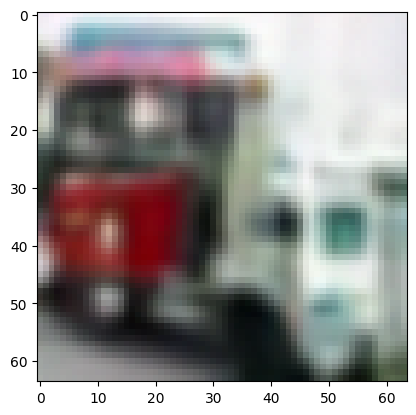

100%|███████████████████████████████████████| 2084/2084 [17:23<00:00,  2.00it/s]


Epoch #81
Current learning rate is 0.00014294235158076457
Train Loss is: 0.010089364849715163


100%|███████████████████████████████████████| 2084/2084 [17:23<00:00,  2.00it/s]


Epoch #82
Current learning rate is 0.0001416558704165377
Train Loss is: 0.010169288380926872


100%|███████████████████████████████████████| 2084/2084 [17:23<00:00,  2.00it/s]


Epoch #83
Current learning rate is 0.00014038096758278886
Train Loss is: 0.010161477514236966


100%|███████████████████████████████████████| 2084/2084 [17:23<00:00,  2.00it/s]


Epoch #84
Current learning rate is 0.00013911753887454375
Train Loss is: 0.010084921290790538


100%|███████████████████████████████████████| 2084/2084 [17:23<00:00,  2.00it/s]


Epoch #85
Current learning rate is 0.00013786548102467285
Train Loss is: 0.010071698271878593


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #86
Current learning rate is 0.0001366246916954508
Train Loss is: 0.010181203299075108


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #87
Current learning rate is 0.00013539506947019174
Train Loss is: 0.010247713719845898


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #88
Current learning rate is 0.00013417651384496
Train Loss is: 0.010137859169443382


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #89
Current learning rate is 0.00013296892522035537
Train Loss is: 0.010033378009876547


100%|█████████████████████████████████████| 10000/10000 [02:16<00:00, 73.41it/s]


Epoch #90
Current learning rate is 0.00013177220489337218
Train Loss is: 0.00998440206638759
Valid Loss is: 0.010491303664460792


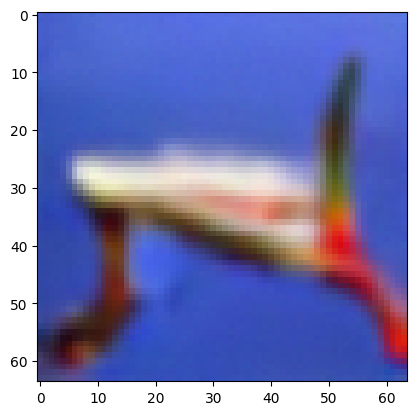

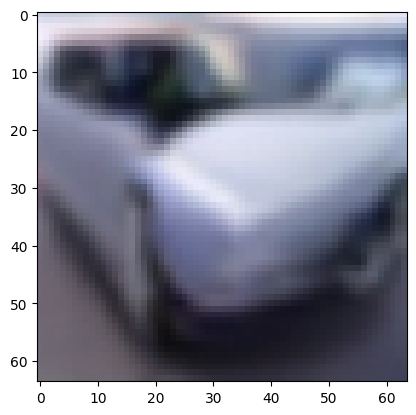

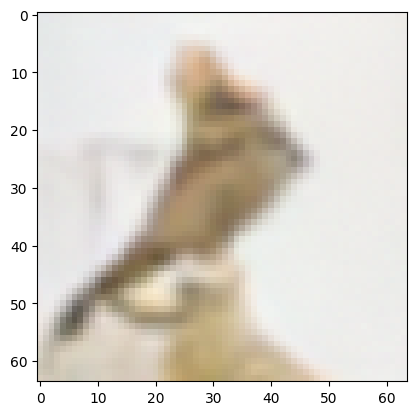

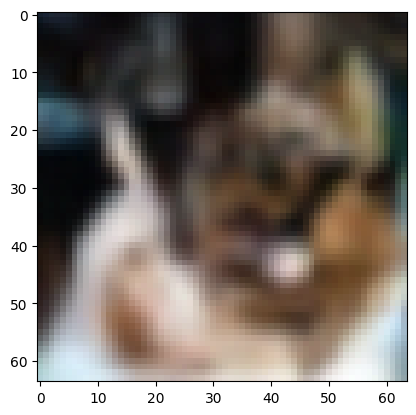

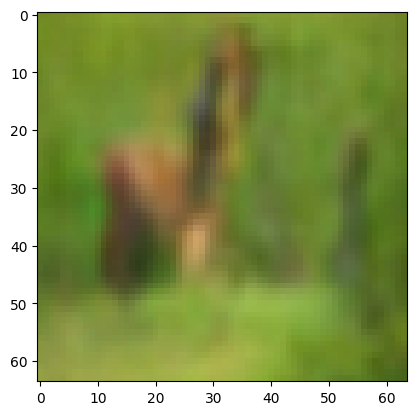

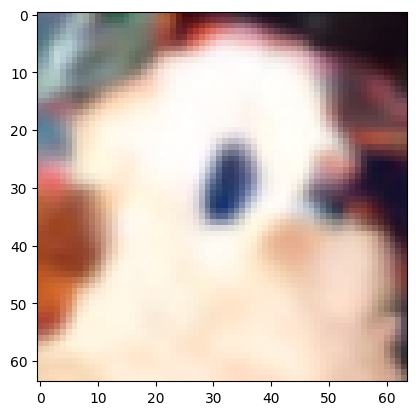

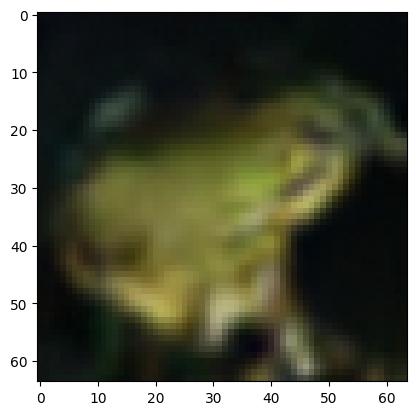

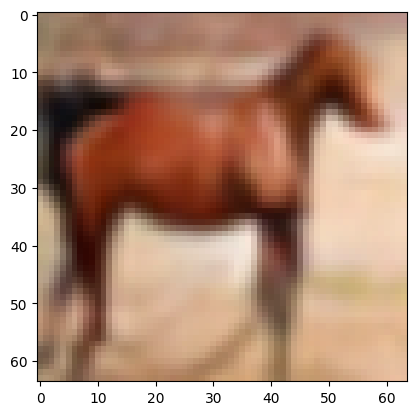

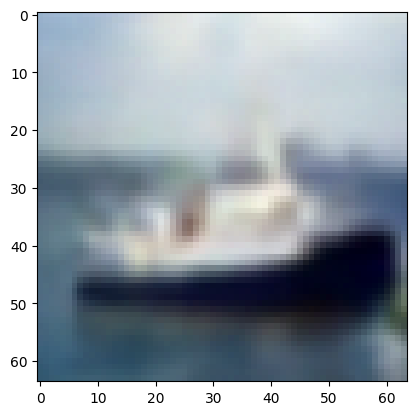

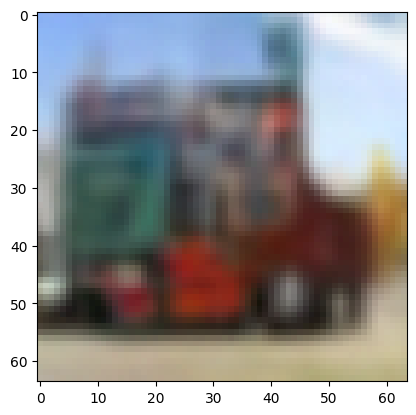

100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #91
Current learning rate is 0.00013058625504933183
Train Loss is: 0.010250777645148748


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #92
Current learning rate is 0.00012941097875388786
Train Loss is: 0.010021746165582539


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #93
Current learning rate is 0.00012824627994510287
Train Loss is: 0.009985300500237252


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #94
Current learning rate is 0.00012709206342559695
Train Loss is: 0.010064891379079897


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #95
Current learning rate is 0.00012594823485476657
Train Loss is: 0.010252185198952105


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #96
Current learning rate is 0.00012481470074107368
Train Loss is: 0.01004739380338821


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #97
Current learning rate is 0.00012369136843440402
Train Loss is: 0.01005552999828111


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #98
Current learning rate is 0.00012257814611849437
Train Loss is: 0.010004228725381403


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #99
Current learning rate is 0.00012147494280342792
Train Loss is: 0.010090620961597086


100%|█████████████████████████████████████| 10000/10000 [02:14<00:00, 74.13it/s]


Epoch #100
Current learning rate is 0.00012038166831819707
Train Loss is: 0.010102261232986203
Valid Loss is: 0.010086611826692207


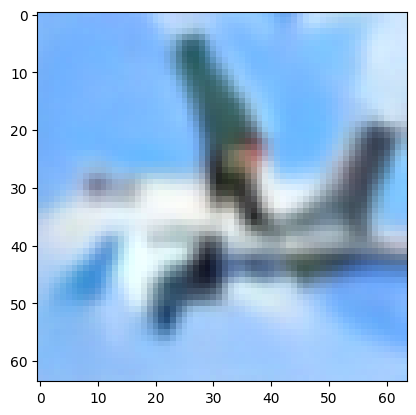

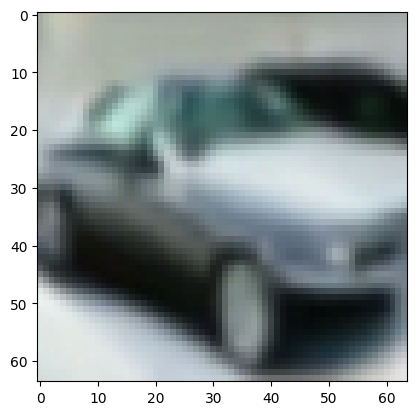

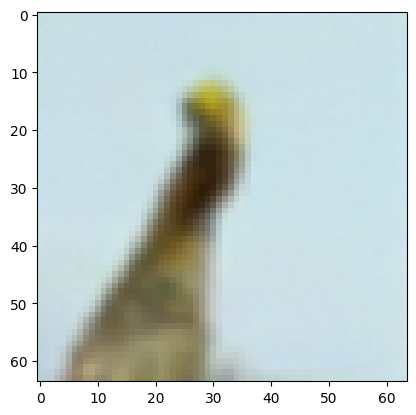

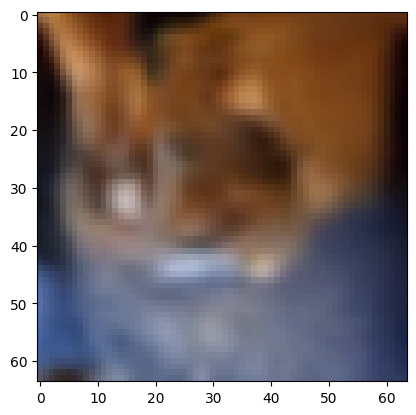

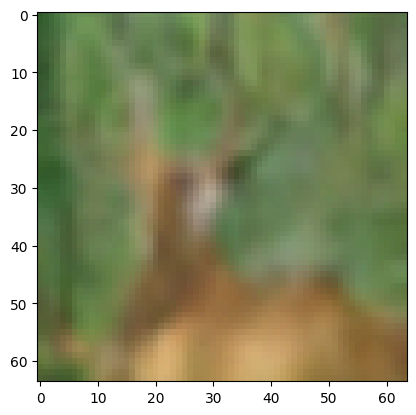

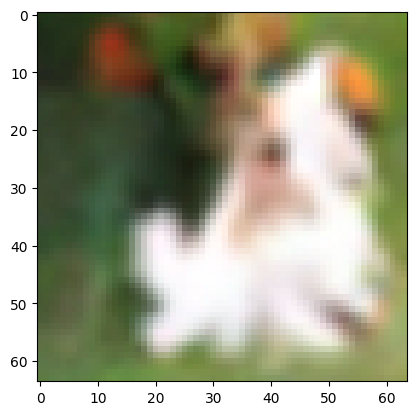

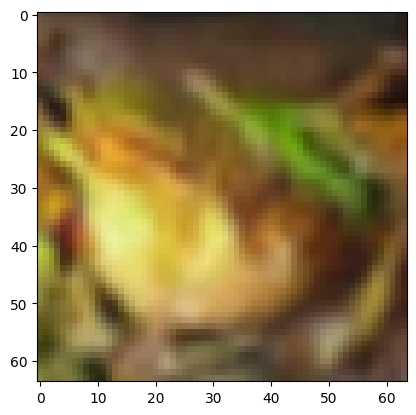

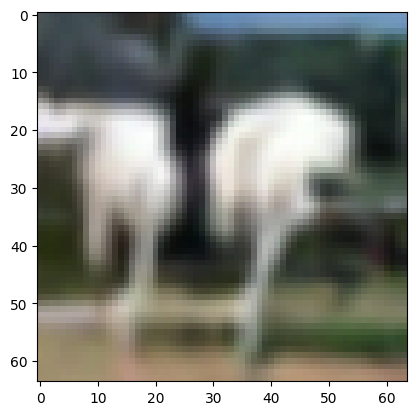

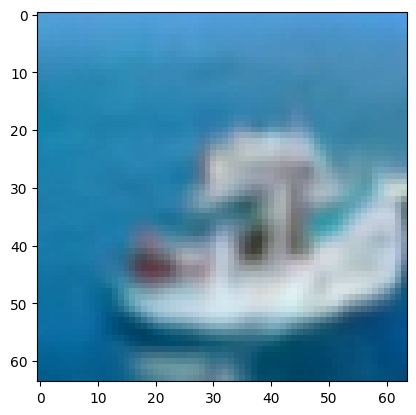

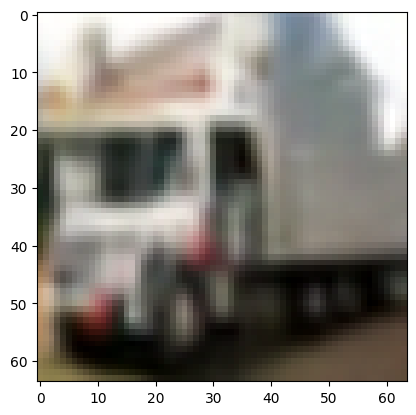

100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #101
Current learning rate is 0.0001192982333033333
Train Loss is: 0.009947436233084639


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #102
Current learning rate is 0.0001182245492036033
Train Loss is: 0.009954467611771699


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #103
Current learning rate is 0.00011716052826077087
Train Loss is: 0.00993502528706991


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #104
Current learning rate is 0.00011610608350642393
Train Loss is: 0.010033235100572553


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #105
Current learning rate is 0.00011506112875486612
Train Loss is: 0.010216641968032148


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #106
Current learning rate is 0.00011402557859607232
Train Loss is: 0.009969291402582944


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #107
Current learning rate is 0.00011299934838870767
Train Loss is: 0.009984021863331232


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #108
Current learning rate is 0.0001119823542532093
Train Loss is: 0.009997339181279345


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #109
Current learning rate is 0.00011097451306493041
Train Loss is: 0.009837665214474114


100%|█████████████████████████████████████| 10000/10000 [02:15<00:00, 73.90it/s]


Epoch #110
Current learning rate is 0.00010997574244734604
Train Loss is: 0.01007994784959708
Valid Loss is: 0.010197927030293067


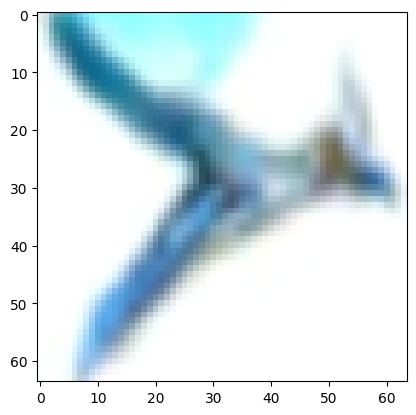

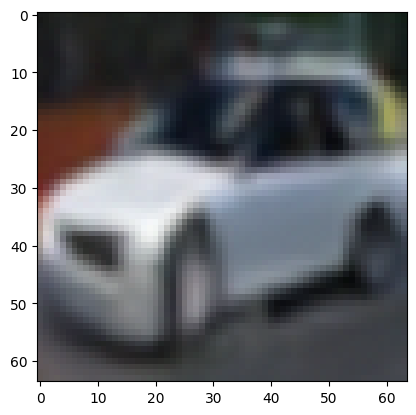

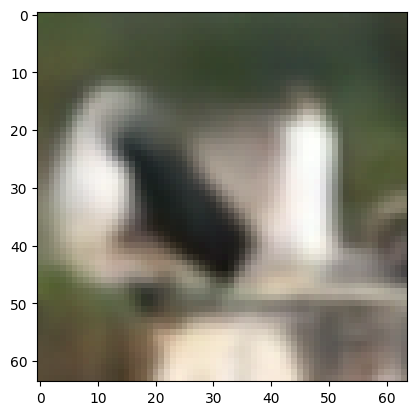

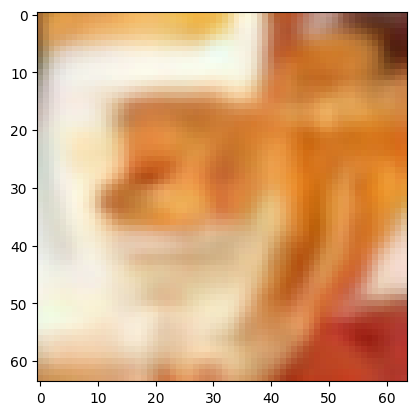

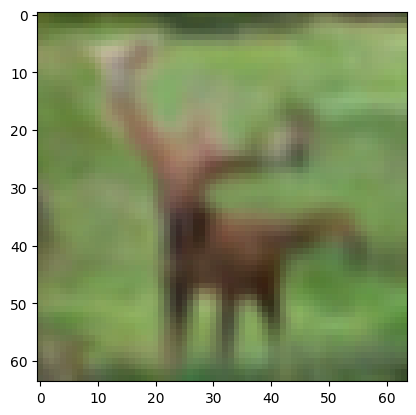

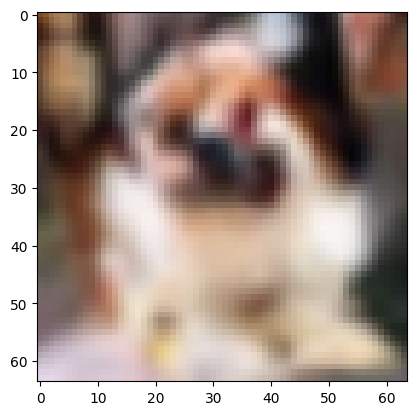

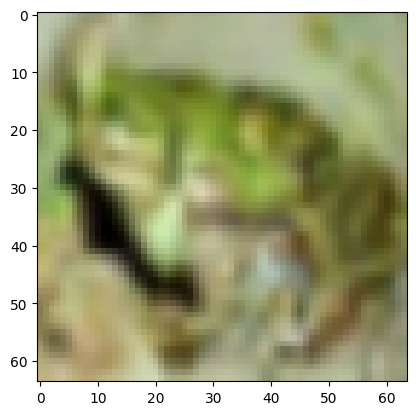

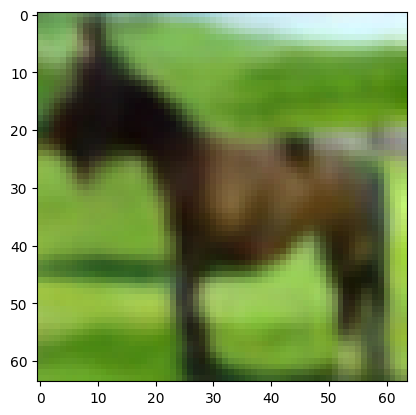

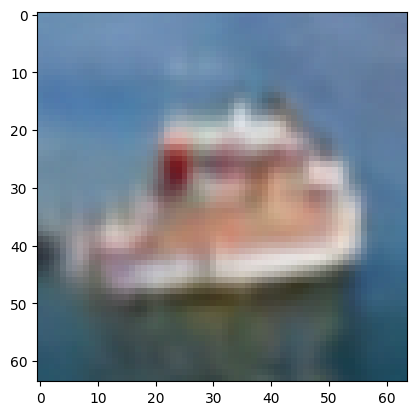

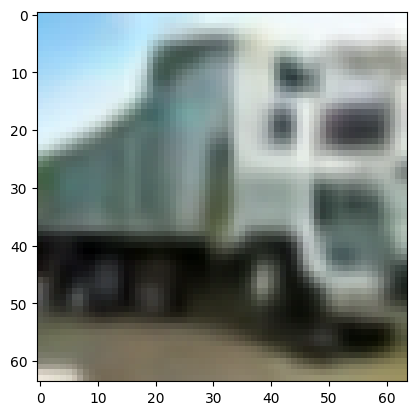

100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #111
Current learning rate is 0.00010898596076531992
Train Loss is: 0.00999548703473644


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #112
Current learning rate is 0.00010800508711843204
Train Loss is: 0.009941664698999375


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #113
Current learning rate is 0.00010703304133436615
Train Loss is: 0.010197087805186382


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #114
Current learning rate is 0.00010606974396235685
Train Loss is: 0.009952212267465024


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #115
Current learning rate is 0.00010511511626669564
Train Loss is: 0.010016743087137365


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #116
Current learning rate is 0.00010416908022029537
Train Loss is: 0.009992539378342482


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #117
Current learning rate is 0.00010323155849831272
Train Loss is: 0.00998738926505552


100%|███████████████████████████████████████| 2084/2084 [17:22<00:00,  2.00it/s]


Epoch #118
Current learning rate is 0.0001023024744718279
Train Loss is: 0.009964819975818941


100%|███████████████████████████████████████| 2084/2084 [17:21<00:00,  2.00it/s]


Epoch #119
Current learning rate is 0.00010138175220158144
Train Loss is: 0.009962893224092497


100%|█████████████████████████████████████| 10000/10000 [02:16<00:00, 73.20it/s]


Epoch #120
Current learning rate is 0.00010046931643176721
Train Loss is: 0.009968487846159203
Valid Loss is: 0.01002628851490026


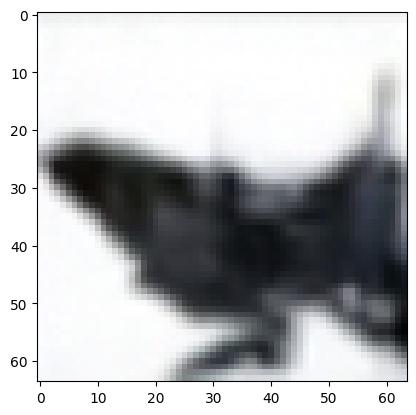

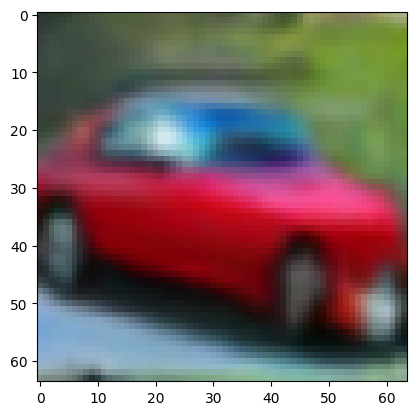

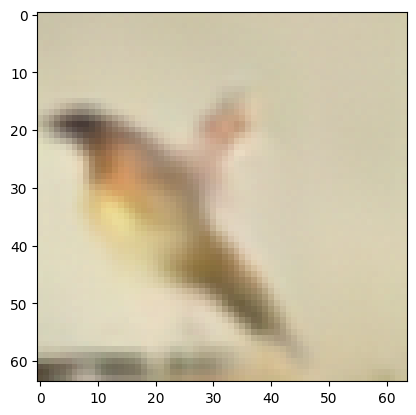

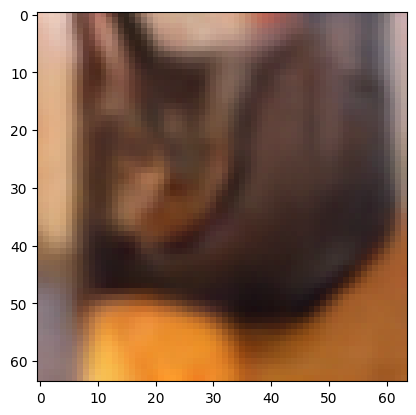

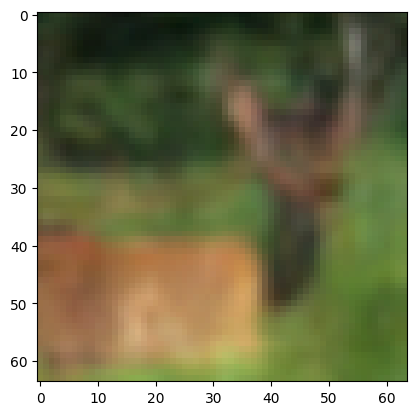

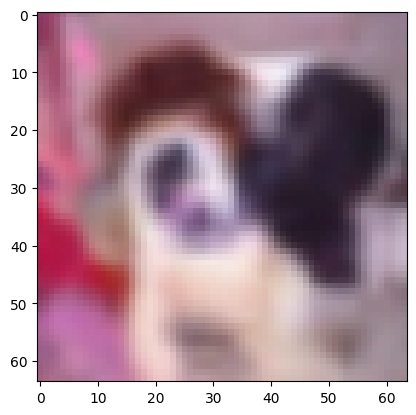

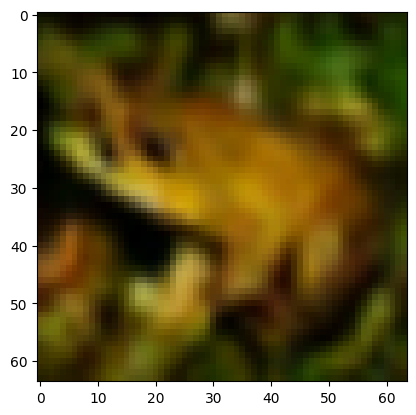

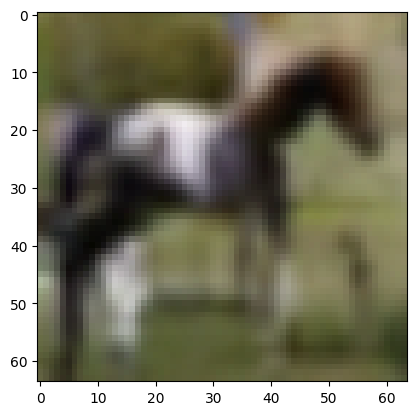

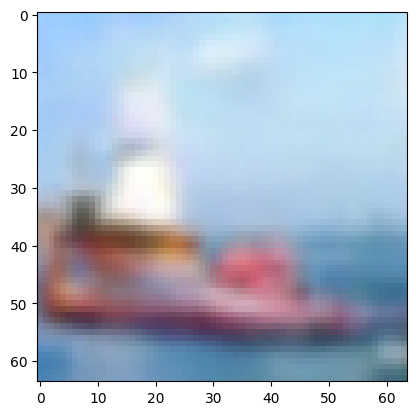

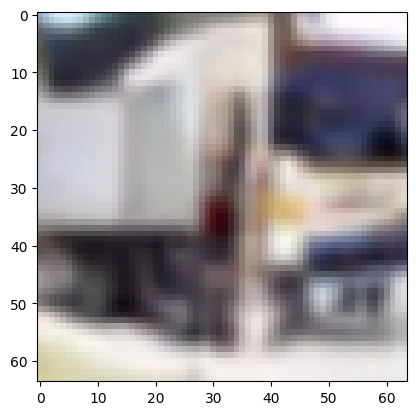

 48%|███████████████████                     | 996/2084 [09:33<11:57,  1.52it/s]

In [ ]:
# Training
ema = EMA(0.9999) # 0.9999 according to the diffusion model beat GANs paper.
ema_model = copy.deepcopy(unet).eval().requires_grad_(False)
for epoch in range(epochs):
    train_loss_list = []
    valid_loss_list = []
    for images, label in tqdm(train_dataloader):
        # Zero out grad
        optimizer.zero_grad()

        # Preparing for forward pass
        images = images.to(device)
        label = label.to(device)
        t = torch.randint(1, steps, size = (images.shape[0], )).to(device)
        pos_emb = pos_emb_matrix[t]
        x_t, noise = forward_pass(images, t)

        # Classifier free guidance.
        if random.random() < 0.1:
            label = None

        # Forward pass
        with amp.autocast():
            predicted_noise = unet(x_t, pos_emb, label)
            loss = criterion(predicted_noise, noise)

        # Back propagation
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # EMA and loss
        ema.step_ema(ema_model, unet)
        train_loss_list.append(loss.item())
    
    if(epoch % 10 == 0):
        with torch.no_grad():
            for images, label in tqdm(valid_dataloader):
                # Preparing for forward pass
                images = images.to(device)
                label = label.to(device)
                t = torch.randint(1, steps, size = (images.shape[0], ))
                pos_emb = pos_emb_matrix[t].to(device)
                x_t, noise = forward_pass(images, t)
    
                # Forward pass
                with amp.autocast():
                    predicted_noise = unet(x_t, pos_emb, label)
                    loss = criterion(predicted_noise, noise)
                valid_loss_list.append(loss.item())

    # Step the learning rate
    scheduler.step()

    print(f"Epoch #{epoch}")
    print(f"Current learning rate is {optimizer.param_groups[0]['lr']}")
    print("Train Loss is:", sum(train_loss_list)/len(train_loss_list))
    loss_train.append(sum(train_loss_list)/len(train_loss_list))576
    if(epoch % 10 == 0):
        print("Valid Loss is:", sum(valid_loss_list)/len(valid_loss_list))
        loss_valid.append(sum(valid_loss_list)/len(valid_loss_list))
    if(epoch % 10 == 0):
        label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)
        sampling(ema_model, label)

# Testing

In [ ]:
label = torch.tensor([0, 0, 0, 0, 0]).to(device)
sampling(ema_model, label, 4)

In [ ]:
torch.save(ema_model, "diffusion_CIFAR10.pth")

In [ ]:
torch.save(unet, "diffusion_CIFAR10_student.pth")